# 6.1 K-Nearest Neighbors for Classification

_Classification models_ are used when the label we want to predict is categorical. In this section, we will train a classification model to predict the color of a wine (red or white) from its chemical properties. 

The training data for the red and white wines are stored in separate files on Github (https://github.com/dlsun/data-science-book/tree/master/data/wines). Let's read in the two datasets, add a column for the color ("red" or "white"), and combine them into one `DataFrame`.

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

reds = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/wines/reds.csv",
                   sep=";")
whites = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/wines/whites.csv", 
                     sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites], 
                  ignore_index=True)
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white
6496,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6,white


Let's focus on just two features for now: volatile acidity and total sulfur dioxide. Let's plot the training data, using color to represent the class label.

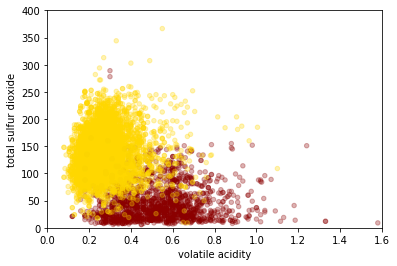

In [2]:
colors = wines["color"].map({
    "red": "darkred",
    "white": "gold"
})

wines.plot.scatter(
    x="volatile acidity", y="total sulfur dioxide", c=colors, 
    alpha=.3, xlim=(0, 1.6), ylim=(0, 400)
);

Now suppose that we have a new wine with volatile acidity .85 and total sulfur dioxide 120, represented by a black circle in the plot below. Is this likely a red wine or a white wine?

![](classification.png)

It is not hard to guess that this wine is probably red, just by looking at the plot. The reasoning goes like this: most of the wines in the training data that were "close" to this wine were red, so it makes sense to predict that this wine is also red. This is precisely the idea behind the $k$-nearest neighbors classifier:

1. Calculate the distance between the new point and each point in the training data, using some distance metric on the features.
2. Determine the $k$ closest points. Of these $k$ closest points, count up how many of each class label there are.
3. The predicted class of the new point is whichever class was most common among the $k$ closest points.

The only difference between the $k$-nearest neighbors classifier and the $k$-nearest neighbors regressor from the previous chapter is the last step. Instead of averaging the labels of the $k$ neighbors to obtain our prediction, we count up the number of occurrences of each category among the labels and take the most common one. It makes sense that we have to do something different because the label is now categorical instead of quantitative. This is yet another example of the general principle that was introduced in Chapter 1: the analysis changes depending on the variable type!

# Implementing the K-Nearest Neighbors Classifier

Let's implement $9$-nearest neighbors for the wine above. First, we extract the training data and scale the features:

In [3]:
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

X_train_sc = (X_train - X_train.mean()) / X_train.std()

Then, we create a `Series` for the new wine, being sure to scale it in the exact same way:

In [4]:
x_new = pd.Series()
x_new["volatile acidity"] = 0.85
x_new["total sulfur dioxide"] = 120

x_new_sc = (x_new - X_train.mean()) / X_train.std()
x_new_sc

volatile acidity        3.099763
total sulfur dioxide    0.075288
dtype: float64

Now we calculate the (Euclidean) distance between this new wine and each wine in the training data, and sort the distances from smallest to largest.

In [6]:
dists = np.sqrt(((X_train_sc - x_new_sc) ** 2).sum(axis=1))
dists_sorted = dists.sort_values()
dists_sorted

782     0.462062
6391    0.466075
          ...   
3726    5.067728
6344    6.700407
Length: 6497, dtype: float64

The first 9 entries of this sorted list will be the 9 nearest neighbors. Let's get their index.

In [7]:
inds_nearest = dists_sorted.index[:9]
inds_nearest

Int64Index([782, 6391, 889, 4696, 198, 637, 636, 46, 6414], dtype='int64')

Now we can look up these indices in the original data.

In [8]:
wines.loc[inds_nearest]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
782,9.0,0.820,0.05,2.4,0.081,26.0,96.0,0.99814,3.36,0.53,10.0,5,red
6391,4.7,0.785,0.00,3.4,0.036,23.0,134.0,0.98981,3.53,0.92,13.8,6,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,7.7,0.935,0.43,2.2,0.114,22.0,114.0,0.99700,3.25,0.73,9.2,5,red
6414,6.2,0.760,0.01,3.2,0.041,18.0,120.0,0.99026,3.20,0.94,13.7,7,white


As a sanity check, notice that these wines are all similar to the new wine in terms of volatile acidity and total sulfur dioxide. To make a prediction for this new wine, we need to count up how many reds and whites there are among these 9-nearest neighbors.

In [9]:
wines.loc[inds_nearest, "color"].value_counts()

red      6
white    3
Name: color, dtype: int64

There were more reds than whites, so the 9-nearest neighbors model predicts that the wine is red.

As a measure of confidence in a prediction, classification models often report the predicted _probability_ of each label, instead of just the predicted label. The predicted probability of a class in a $k$-nearest neighbors model is simply the proportion of the $k$ neighbors that are in that class. In the example above, instead of simply predicting that the wine is red, we could have instead said that the wine has a $6/9 = .667$ probability of being red.

# K-Nearest Neighbors Classifier in Scikit-Learn

Now let's see how to implement the same $9$-nearest neighbors model above using Scikit-Learn.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# define the training data
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

# fit the 9-nearest neighbors model
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_sc, y_train)

# define the test data (Scikit-Learn expects a matrix)
x_new = pd.DataFrame()
x_new["volatile acidity"] = [0.85]
x_new["total sulfur dioxide"] = [120]
x_new_sc = scaler.transform(x_new)

# use the model to predict on the test data
model.predict(x_new_sc)

array(['red'], dtype=object)

What if we want the predicted probabilities? For classification models, there is an additional method, `.predict_proba()`, that returns the predicted probability of each class.

In [11]:
model.predict_proba(x_new_sc)

array([[ 0.66666667,  0.33333333]])

The first number represents the probability of the first class ("red") and the second number represents the probability of the second class ("white"). Notice that the predicted probabilities add up to 1, as they must.

# Exercises

**Exercise 1.** In the above example, we built a 9-nearest neighbors classifier to predict the color of a wine from just its volatile acidity and total sulfur dioxide. Use the model above to predict the color of a wine with the following features:

- fixed acidity: 11
- volatile acidity: 0.3
- citric acid: 0.3
- residual sugar: 2
- chlorides: 0.08
- free sulfur dioxide: 17
- total sulfur dioxide: 60
- density: 1.0
- pH: 3.2
- sulphates: 0.6
- alcohol: 9.8
- quality: 6

Now, build a 15-nearest neighbors classifier using all of the features in the data set. Use this new model to predict the color of the same wine above.

Does the predicted label change? Do the predicted probabilities of the labels change?

In [25]:
X_train = wines.drop("color", axis=1)
y_train = wines["color"]

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
model = KNeighborsClassifier(n_neighbors=15)
model.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [27]:
# define the test data (Scikit-Learn expects a matrix)
x_new = pd.DataFrame()
x_new["fixed acidity"] = [11]
x_new["volatile acidity"] = [0.3]
x_new["citric acid"] = [0.3]
x_new["residual sugar"] = [2]
x_new["chlorides"] = [0.08]
x_new["free sulfur dioxide"] = [17]
x_new["total sulfur dioxide"] = [60]
x_new["density"] = [1.0]
x_new["pH"] = [3.2]
x_new["sulphates"] = [0.6]
x_new["alcohol"] = [9.8]
x_new["quality"] = [6]

x_new_sc = scaler.transform(x_new)

In [22]:
model.predict_proba(x_new_sc)

array([[ 1.,  0.]])

**Exercise 2.** Build a 5-nearest neighbors model to predict whether or not a passenger on a Titanic would survive, based on their age, sex, and class as features. Use the Titanic data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv`) as your training data. Then, use your model to predict whether a 20-year old female in first-class would survive. What about a 20-year old female in third-class?

In [86]:
titanic_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv")[["age", "sex", "pclass", "survived"]].dropna()
titanic_df.pclass = titanic_df.pclass.astype('category')
titanic_df.survived = titanic_df.survived.astype('category')
titanic_df.head()

,age,sex,pclass,survived
0,29.0000,female,1,1
1,0.9167,male,1,1
2,2.0000,female,1,0
3,30.0000,male,1,0
4,25.0000,female,1,0


In [87]:
X_train = titanic_df.drop("survived", axis=1)
y_train = titanic_df["survived"]

In [130]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier

X_dict = X_train.to_dict(orient="records")

vec = DictVectorizer(sparse=False)
norm = Normalizer()
model = KNeighborsClassifier(n_neighbors=5)

X_train_vec = vec.fit_transform(X_dict)
X_train_norm = norm.fit_transform(X_train_vec)
fit_model = model.fit(X_train_norm, y_train)

In [133]:
X_new = pd.DataFrame()
X_new['sex'] = ["female", "male", "female", "male"]
X_new['age'] = [20.0, 30, 20, 30]
X_new['pclass'] = ["1", "1", "3", "3"]
X_new

,sex,age,pclass
0,female,20.0,1
1,male,30.0,1
2,female,20.0,3
3,male,30.0,3


In [134]:
X_new_dict = X_new.to_dict(orient="records")
X_new_vec = vec.transform(X_new_dict)
X_new_norm = norm.transform(X_new_vec)
fit_model.predict_proba(X_new_norm)

array([[ 0. ,  1. ],
       [ 0.8,  0.2],
       [ 0. ,  1. ],
       [ 0.8,  0.2]])